In [123]:
# Data manipulation
import pandas as pd
import numpy as np
import pyarrow

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb  # ML algorithm for forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Error metrics

In [124]:
import time

# Record the start time
start_time = time.time()

Referenced from: https://github.com/jpsam07/skyline-hospital-time-series-forecasting-with-xgboost?tab=readme-ov-file#data-collection

In [125]:
filepath = 'sample-data/sensor_50.csv' # change as needed

df = pd.read_csv(filepath)

df.head()


,date,50
0,2018-03-18 02:00:00,0.0175
1,2018-03-18 03:00:00,0.0134
2,2018-03-18 04:00:00,0.0129
3,2018-03-18 05:00:00,0.0095
4,2018-03-18 06:00:00,0.0115


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2544 non-null   object 
 1   50      2544 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.9+ KB


In [127]:
df = df.set_index('date')
df

,50
date,
2018-03-18 02:00:00,0.0175
2018-03-18 03:00:00,0.0134
2018-03-18 04:00:00,0.0129
2018-03-18 05:00:00,0.0095
2018-03-18 06:00:00,0.0115
...,...
2018-07-01 21:00:00,0.0457
2018-07-01 22:00:00,0.0421
2018-07-01 23:00:00,0.0412


In [128]:
# Convert sensor columns to numeric (in case they are not already)
# df['sensor'] = df.iloc[:, 0:10].mean(axis=1)
#df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Calculate the average across sensor columns
# df['sensor'] = df.iloc[:, 1:].mean(axis=1)

# Drop the individual sensor columns
# df.drop(columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], inplace=True)

# Display the updated DataFrame
df.rename(columns={'50': 'Traffic'}, inplace=True)
print(df.head())


                     Traffic
date                        
2018-03-18 02:00:00   0.0175
2018-03-18 03:00:00   0.0134
2018-03-18 04:00:00   0.0129
2018-03-18 05:00:00   0.0095
2018-03-18 06:00:00   0.0115


In [129]:
df = df.copy()
df['date'] = pd.to_datetime(df.index)
df['day_of_week'] = df['date'].dt.dayofweek
print(df.head())

print(df.tail())

                     Traffic                date  day_of_week
date                                                         
2018-03-18 02:00:00   0.0175 2018-03-18 02:00:00            6
2018-03-18 03:00:00   0.0134 2018-03-18 03:00:00            6
2018-03-18 04:00:00   0.0129 2018-03-18 04:00:00            6
2018-03-18 05:00:00   0.0095 2018-03-18 05:00:00            6
2018-03-18 06:00:00   0.0115 2018-03-18 06:00:00            6
                     Traffic                date  day_of_week
date                                                         
2018-07-01 21:00:00   0.0457 2018-07-01 21:00:00            6
2018-07-01 22:00:00   0.0421 2018-07-01 22:00:00            6
2018-07-01 23:00:00   0.0412 2018-07-01 23:00:00            6
2018-07-02 00:00:00   0.0475 2018-07-02 00:00:00            0
2018-07-02 01:00:00   0.0480 2018-07-02 01:00:00            0


<Axes: xlabel='day_of_week'>

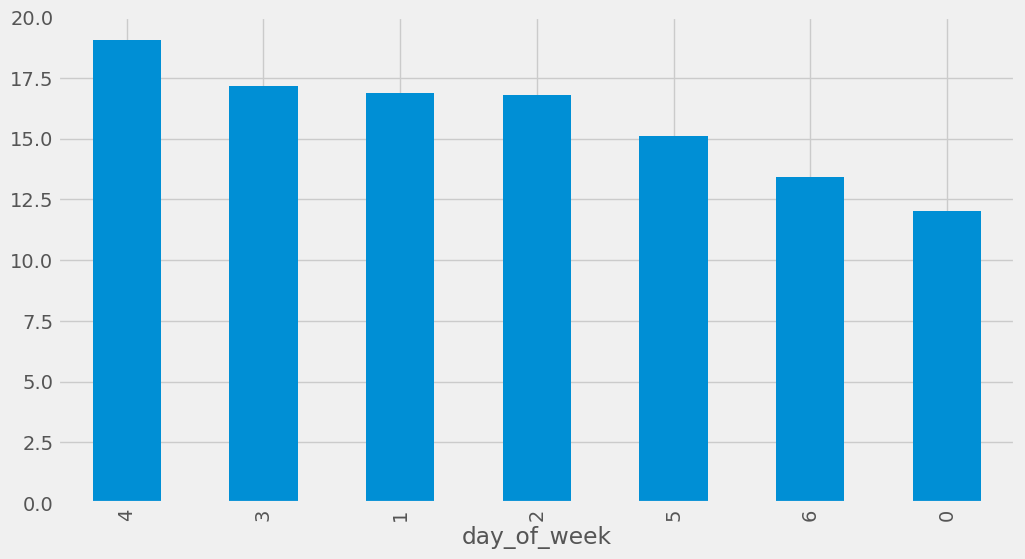

In [130]:
df.groupby('day_of_week')['Traffic'].sum().sort_values(ascending=False) \
    .plot(kind='bar', figsize=(11, 6))


In [131]:
from statsmodels.tsa.seasonal import STL

In [132]:
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Assuming 'Traffic' is the column containing the traffic data
traffic_series = df['Traffic']

# Step 1: Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Step 2: Extract 'Traffic' as a pandas Series
traffic_series = df['Traffic']

# Step 3: Convert the data type of the Series to numeric (if needed)
traffic_series = pd.to_numeric(traffic_series, errors='coerce')

# Perform STL decomposition
stl = STL(traffic_series, seasonal= 7)  # Assuming hourly data with weekly seasonality
result = stl.fit()

print(stl, result, sep='\n')


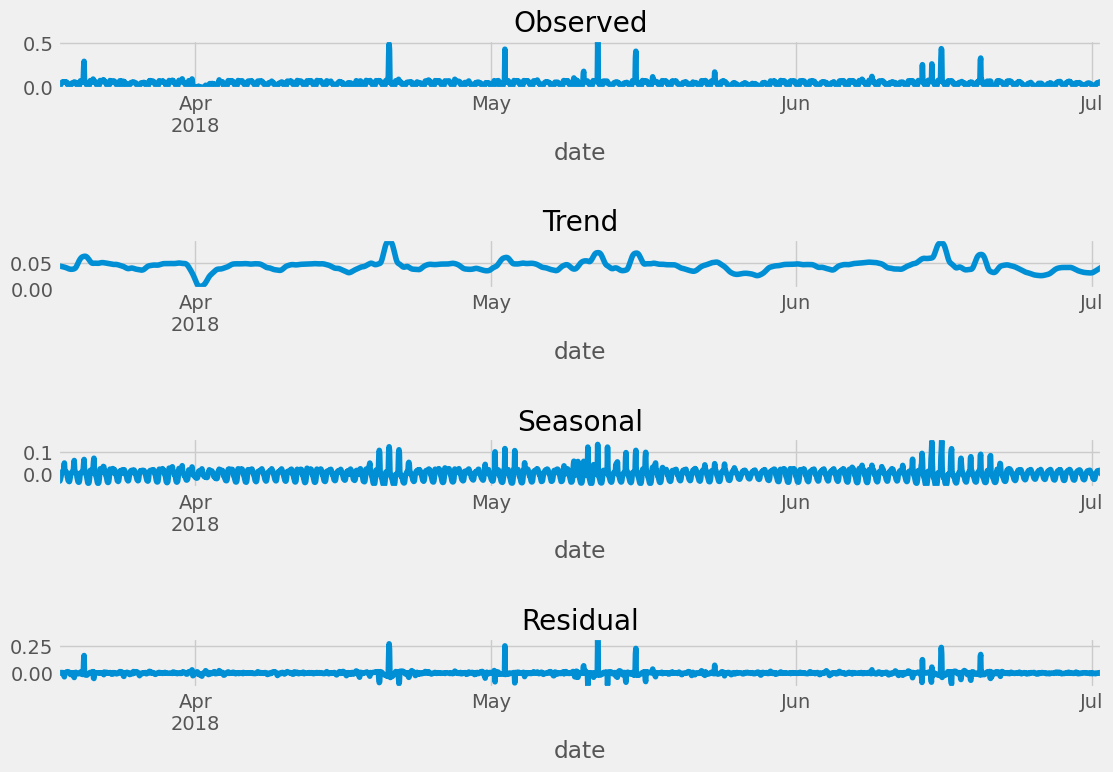

In [133]:
# Plot the components
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=3)

# Observed component
result.observed.plot(ax=ax[0], legend=False)
ax[0].set_title('Observed')

# Trend component
result.trend.plot(ax=ax[1], legend=False)
ax[1].set_title('Trend')

# Seasonal component
result.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_title('Seasonal')

# Residual component
result.resid.plot(ax=ax[3], legend=False)
ax[3].set_title('Residual')

# Show plot
plt.show()

In [134]:
# Calculate the 25th and 75th quantiles and the IQR
Q1 = traffic_series.quantile(0.25)
Q3 = traffic_series.quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 0.9 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')

Lower Bound: 0.01565
Upper Bound: 0.09864999999999999


In [135]:
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = traffic_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Traffic'] = cleaned_series.copy()

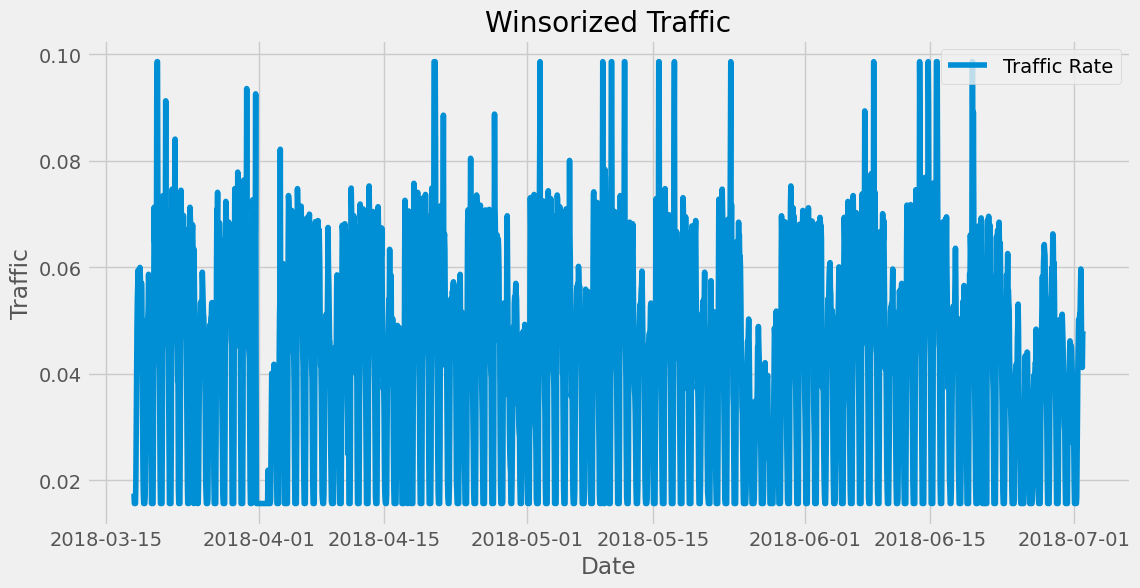

In [136]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized time series data
ax.plot(df.index, 'Traffic', data=df,
       label='Traffic Rate')

# Plot title and labels
ax.set_title('Winsorized Traffic')
ax.set_xlabel('Date')
ax.set_ylabel('Traffic')

# Show legend
plt.legend()

# Show plot
plt.show()

In [137]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour  # Add hour feature
    
    window_size = 7  # 7-day rolling window
    
    # Rolling minimum
    df['rolling_min'] = df['Traffic'].rolling(window=window_size).min()
    
    # Rolling maximum
    df['rolling_max'] = df['Traffic'].rolling(window=window_size).max()
    
    # Rolling sum
    df['rolling_sum'] = df['Traffic'].rolling(window=window_size).sum()
    
    # Rollling mean
    df['rolling_mean'] = df['Traffic'].rolling(window=window_size).mean()
    
    # Rolling median
    df['rolling_median'] = df['Traffic'].rolling(window=window_size).median()
    
    # Rolling standard deviation
    df['rolling_std'] = df['Traffic'].rolling(window=window_size).std()
    
    # Rolling 25th percentile
    df['rolling_quantile_25'] = df['Traffic'].rolling(window=window_size).quantile(0.25)
    
    # Rolling 75th percentile
    df['rolling_quantile_75'] = df['Traffic'].rolling(window=window_size).quantile(0.75)
    return df

df = create_features(df)
df.dtypes

Traffic                       float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
hour                            int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
dtype: object

In [138]:
from sklearn.model_selection import TimeSeriesSplit

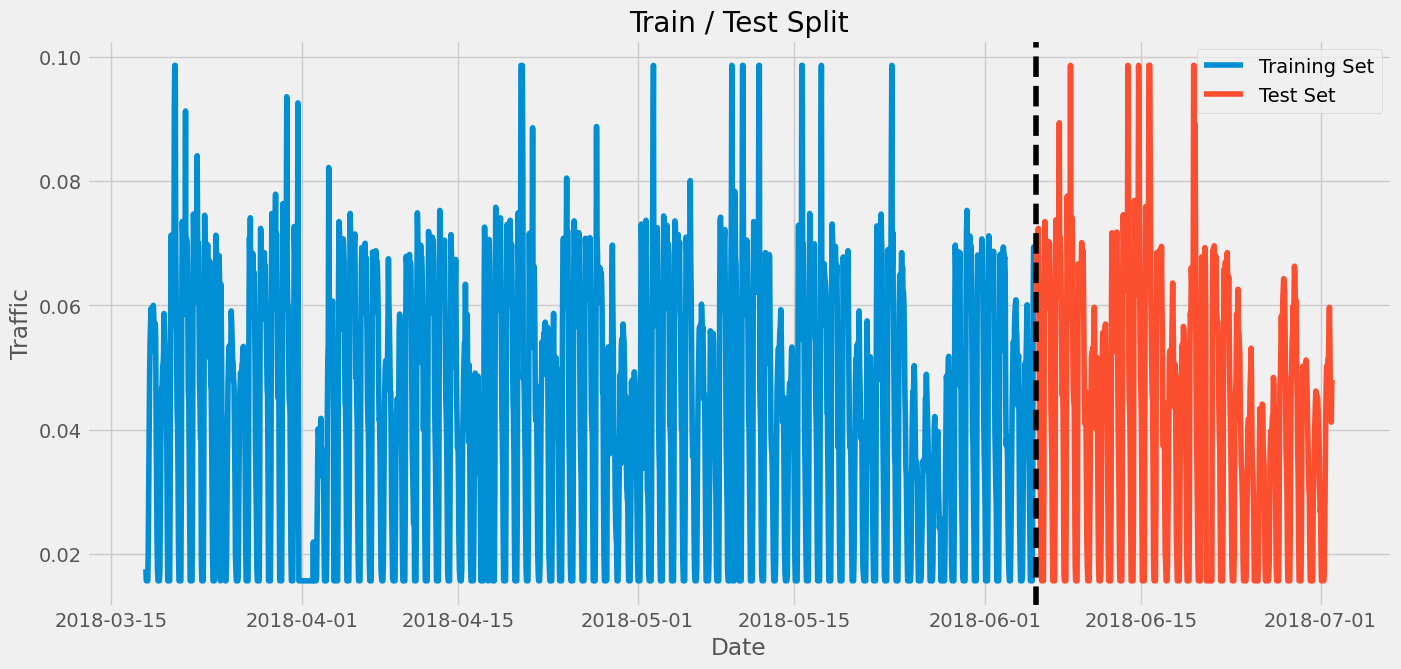

In [139]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
train_size = 0.75
train, test = train_test_split(df, test_size=(1 - train_size), shuffle=False)

# Plotting the data
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['Traffic'], label='Training Set')
plt.plot(test.index, test['Traffic'], label='Test Set')
plt.axvline(test.index.min(), color='black', ls='--')
plt.title('Train / Test Split')
plt.xlabel('Date')
plt.ylabel('Traffic')
plt.legend()
plt.show()


In [140]:
df

,Traffic,date,day_of_week,month,day_of_year,hour,rolling_min,rolling_max,rolling_sum,rolling_mean,rolling_median,rolling_std,rolling_quantile_25,rolling_quantile_75
date,,,,,,,,,,,,,,
2018-03-18 02:00:00,0.01750,2018-03-18 02:00:00,6,3,77,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 03:00:00,0.01565,2018-03-18 03:00:00,6,3,77,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 04:00:00,0.01565,2018-03-18 04:00:00,6,3,77,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 05:00:00,0.01565,2018-03-18 05:00:00,6,3,77,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 06:00:00,0.01565,2018-03-18 06:00:00,6,3,77,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-01 21:00:00,0.04570,2018-07-01 21:00:00,6,7,182,21,0.0457,0.0597,0.3680,0.052571,0.0518,0.004496,0.05055,0.05485
2018-07-01 22:00:00,0.04210,2018-07-01 22:00:00,6,7,182,22,0.0421,0.0597,0.3604,0.051486,0.0518,0.005978,0.04855,0.05485
2018-07-01 23:00:00,0.04120,2018-07-01 23:00:00,6,7,182,23,0.0412,0.0597,0.3502,0.050029,0.0518,0.007134,0.04390,0.05485


In [141]:
def add_lags(df):
    """
    Create time lags for added time series features and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Traffic'].to_dict()
    df['lag_1_hour'] = (df.index - pd.Timedelta('1 hours')).map(target_map)
    df['lag_2_hours'] = (df.index - pd.Timedelta('2 hours')).map(target_map)
    df['lag_3_hours'] = (df.index - pd.Timedelta('3 hours')).map(target_map)

    df['lag_7_days'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_14_days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_21_days'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag_28_days'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_30_days'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag_35_days'] = (df.index - pd.Timedelta('35 days')).map(target_map)
    df['lag_42_days'] = (df.index - pd.Timedelta('42 days')).map(target_map)
    df['lag_49_days'] = (df.index - pd.Timedelta('49 days')).map(target_map)
    df['lag_56_days'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag_60_days'] = (df.index - pd.Timedelta('60 days')).map(target_map)

     # Daily lags
    for lag_days in range(1, 7):  # lags for 1 to 6 days
        df[f'lag_{lag_days}_days'] = (df.index - pd.Timedelta(f'{lag_days} days')).map(target_map)
    
    return df

df = add_lags(df)
df

,Traffic,date,day_of_week,month,day_of_year,hour,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_42_days,lag_49_days,lag_56_days,lag_60_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days
date,,,,,,,,,,,,,,,,,,,,,
2018-03-18 02:00:00,0.01750,2018-03-18 02:00:00,6,3,77,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 03:00:00,0.01565,2018-03-18 03:00:00,6,3,77,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 04:00:00,0.01565,2018-03-18 04:00:00,6,3,77,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 05:00:00,0.01565,2018-03-18 05:00:00,6,3,77,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 06:00:00,0.01565,2018-03-18 06:00:00,6,3,77,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-01 21:00:00,0.04570,2018-07-01 21:00:00,6,7,182,21,0.0457,0.0597,0.3680,0.052571,...,0.0470,0.0490,0.0515,0.04160,0.0371,0.0368,0.0488,0.0461,0.0409,0.0374
2018-07-01 22:00:00,0.04210,2018-07-01 22:00:00,6,7,182,22,0.0421,0.0597,0.3604,0.051486,...,0.0403,0.0441,0.0449,0.03610,0.0309,0.0339,0.0449,0.0366,0.0365,0.0356
2018-07-01 23:00:00,0.04120,2018-07-01 23:00:00,6,7,182,23,0.0412,0.0597,0.3502,0.050029,...,0.0385,0.0412,0.0457,0.03310,0.0268,0.0303,0.0364,0.0340,0.0346,0.0340


In [142]:
# Define error metrics

# Root mean squared error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y_true,  y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Symmetric mean absolute percentage error (sMAPE)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Mean Absolute Error (MAE)
def mean_absolute_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

# Mean Squared Error (MSE)
def mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

In [143]:
df.columns

Index(['Traffic', 'date', 'day_of_week', 'month', 'day_of_year', 'hour',
       'rolling_min', 'rolling_max', 'rolling_sum', 'rolling_mean',
       'rolling_median', 'rolling_std', 'rolling_quantile_25',
       'rolling_quantile_75', 'lag_1_hour', 'lag_2_hours', 'lag_3_hours',
       'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days',
       'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days',
       'lag_56_days', 'lag_60_days', 'lag_1_days', 'lag_2_days', 'lag_3_days',
       'lag_4_days', 'lag_5_days', 'lag_6_days'],
      dtype='object')

In [144]:
df.dtypes

Traffic                       float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
hour                            int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
lag_1_hour                    float64
lag_2_hours                   float64
lag_3_hours                   float64
lag_7_days                    float64
lag_14_days                   float64
lag_21_days                   float64
lag_28_days                   float64
lag_30_days                   float64
lag_35_days                   float64
lag_42_days                   float64
lag_49_days                   float64
lag_56_days                   float64
lag_60_days 

In [145]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming df is your DataFrame and create_features is a function to generate features
train, test = train_test_split(df, test_size=(1-train_size), shuffle=False)

train = create_features(train)
test = create_features(test)

# Make empty lists for the error metric scores
rmse_scores = []
mape_scores = []
smape_scores = []
mae_scores = []
mse_scores = []

FEATURES = ['hour','day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
            'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
            'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days',
            'lag_1_hour', 'lag_2_hours', 'lag_3_hours',
            'lag_1_days', 'lag_2_days', 'lag_3_days', 'lag_4_days', 'lag_5_days','lag_6_days']

TARGET = 'Traffic'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=900, 
                       early_stopping_rounds=50, 
                       tree_method='hist',
                       objective='reg:squarederror', 
                       max_depth=3, 
                       min_child_weight=3, 
                       gamma=0, 
                       learning_rate=0.01, 
                       colsample_bytree=0.9, 
                       subsample=0.7,
                       reg_lambda=0)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

y_pred = reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Calculate additional metrics if needed
mape = mean_absolute_percentage_error(y_test, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)

# Store the scores
rmse_scores.append(rmse)
mape_scores.append(mape)
smape_scores.append(smape)
mae_scores.append(mae)
mse_scores.append(mse)

# Store actual and predicted values along with their datetime index in the DataFrame
actual_vs_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=test.index)


[0]	validation_0-rmse:0.45269	validation_1-rmse:0.45335


[100]	validation_0-rmse:0.16581	validation_1-rmse:0.16598
[200]	validation_0-rmse:0.06090	validation_1-rmse:0.06103
[300]	validation_0-rmse:0.02275	validation_1-rmse:0.02294
[400]	validation_0-rmse:0.00935	validation_1-rmse:0.00972
[500]	validation_0-rmse:0.00529	validation_1-rmse:0.00587
[600]	validation_0-rmse:0.00433	validation_1-rmse:0.00506
[700]	validation_0-rmse:0.00405	validation_1-rmse:0.00492
[800]	validation_0-rmse:0.00392	validation_1-rmse:0.00491
[839]	validation_0-rmse:0.00387	validation_1-rmse:0.00491


In [ ]:
# Print the error metric results
print(f'RMSE across folds: {np.mean(rmse_scores):.16f}')
print(f'MAPE across folds: {np.mean(mape_scores):.3f}%')
print(f'sMAPE across folds: {np.mean(smape_scores):.3f}%')
print(f'MAE across folds: {np.mean(mae_scores):.16f}')
print(f'MSE across folds: {np.mean(mse_scores):.16f}')

RMSE across folds: 0.0050546590152700
MAPE across folds: 8.790%
sMAPE across folds: 7.899%
MAE across folds: 0.0030531049578679
MSE across folds: 0.0000255495777607


In [ ]:
# Display the DataFrame
actual_vs_pred_df

,Actual,Predicted
date,,
2018-06-10 21:00:00,0.0427,0.052124
2018-06-10 22:00:00,0.0402,0.039471
2018-06-10 23:00:00,0.0427,0.038365
2018-06-11 00:00:00,0.0491,0.039133
2018-06-11 01:00:00,0.0516,0.046019
...,...,...
2018-07-01 21:00:00,0.0457,0.046510
2018-07-01 22:00:00,0.0421,0.040985
2018-07-01 23:00:00,0.0412,0.037600


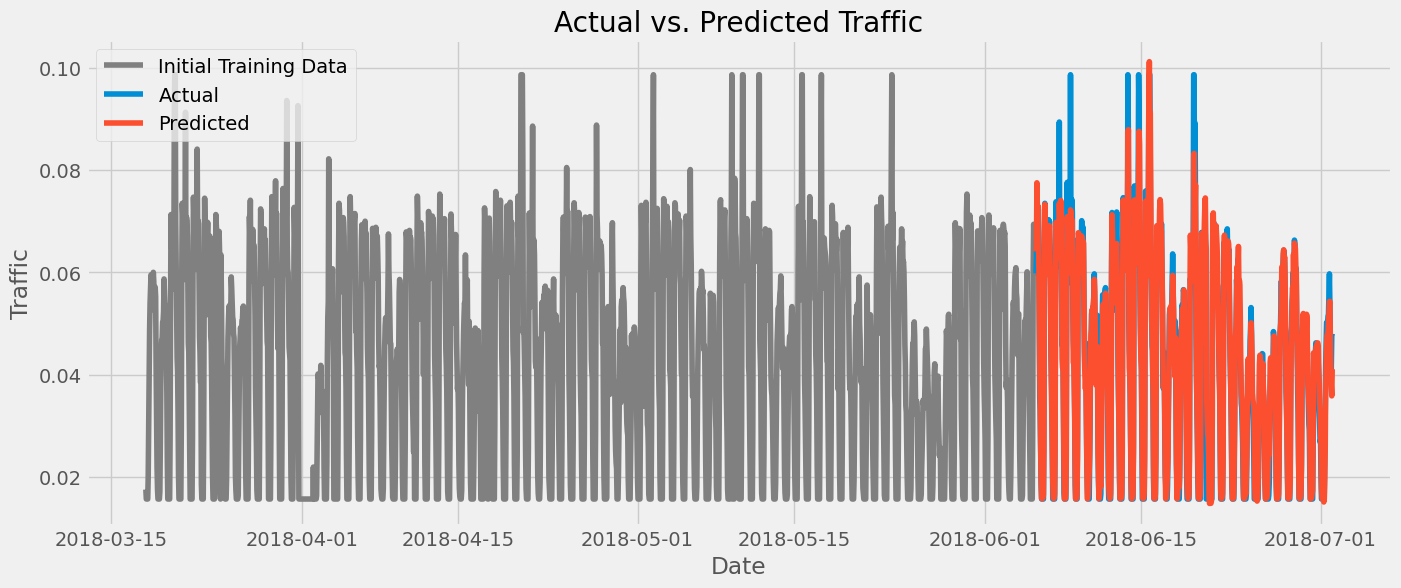

In [147]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot the initial training data
plt.plot(train.index, train['Traffic'], label='Initial Training Data', color='gray')

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual')
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted')

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Traffic')
plt.title('Actual vs. Predicted Traffic')

# Show legend
plt.legend()

# Show plot
plt.show()


In [ ]:
df
df.to_csv('xgboost-df-processed.csv', index=False)

In [ ]:
# Retrain on all the data
df = create_features(df)

FEATURES = ['hour','day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
            'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
            'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days',
            'lag_1_hour', 'lag_2_hours', 'lag_3_hours',
            'lag_1_days', 'lag_2_days', 'lag_3_days', 'lag_4_days', 'lag_5_days','lag_6_days']

TARGET = 'Traffic'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=400,
                       early_stopping_rounds=50,
                       tree_method='hist',
                       objective='reg:squarederror',
                       max_depth=3,
                       min_child_weight=3,
                       gamma=0,
                       learning_rate=0.01,
                       colsample_bytree=0.5,
                       subsample=0.7,
                       reg_lambda=0)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)],
       verbose=100)

[0]	validation_0-rmse:0.45286
[100]	validation_0-rmse:0.16589


[200]	validation_0-rmse:0.06095
[300]	validation_0-rmse:0.02278
[399]	validation_0-rmse:0.00948


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
df.index.max()

Timestamp('2018-07-02 01:00:00')

In [ ]:
first_date_time = df.iloc[0]['date']
last_date_time = df.iloc[-1]['date']
#print(last_date_time)

new_date_time = last_date_time + pd.DateOffset(months=3)
#print(new_date_time)

first_date_time_str = first_date_time.strftime('%Y-%m-%d %H:%M:%S')
last_date_time_str = last_date_time.strftime('%Y-%m-%d %H:%M:%S')
new_date_time_str = new_date_time.strftime('%Y-%m-%d %H:%M:%S')
print(first_date_time_str)
print(last_date_time_str)
#print(new_date_time_str)

2018-03-18 02:00:00
2018-07-02 01:00:00


In [ ]:
future = pd.date_range('2022-12-31', '2023-06-28', freq='D')
future_df = pd.DataFrame(index=future)

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future

,Traffic,date,day_of_week,month,day_of_year,hour,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_42_days,lag_49_days,lag_56_days,lag_60_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days
2018-03-18 02:00:00,0.01750,2018-03-18 02:00:00,6,3,77,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 03:00:00,0.01565,2018-03-18 03:00:00,6,3,77,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 04:00:00,0.01565,2018-03-18 04:00:00,6,3,77,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 05:00:00,0.01565,2018-03-18 05:00:00,6,3,77,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-18 06:00:00,0.01565,2018-03-18 06:00:00,6,3,77,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-24 00:00:00,NaN,2023-06-24 00:00:00,5,6,175,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-25 00:00:00,NaN,2023-06-25 00:00:00,6,6,176,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-26 00:00:00,NaN,2023-06-26 00:00:00,0,6,177,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-27 00:00:00,NaN,2023-06-27 00:00:00,1,6,178,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create future DataFrame with hourly frequency
future = pd.date_range(start=last_date_time_str, end=new_date_time_str, freq='D')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

df
#df_and_future


,Traffic,date,day_of_week,month,day_of_year,hour,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_49_days,lag_56_days,lag_60_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,isFuture
date,,,,,,,,,,,,,,,,,,,,,
2018-03-18 02:00:00,0.01750,2018-03-18 02:00:00,6,3,77,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-03-18 03:00:00,0.01565,2018-03-18 03:00:00,6,3,77,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-03-18 04:00:00,0.01565,2018-03-18 04:00:00,6,3,77,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-03-18 05:00:00,0.01565,2018-03-18 05:00:00,6,3,77,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-03-18 06:00:00,0.01565,2018-03-18 06:00:00,6,3,77,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-01 21:00:00,0.04570,2018-07-01 21:00:00,6,7,182,21,0.0457,0.0597,0.3680,0.052571,...,0.0490,0.0515,0.04160,0.0371,0.0368,0.0488,0.0461,0.0409,0.0374,False
2018-07-01 22:00:00,0.04210,2018-07-01 22:00:00,6,7,182,22,0.0421,0.0597,0.3604,0.051486,...,0.0441,0.0449,0.03610,0.0309,0.0339,0.0449,0.0366,0.0365,0.0356,False
2018-07-01 23:00:00,0.04120,2018-07-01 23:00:00,6,7,182,23,0.0412,0.0597,0.3502,0.050029,...,0.0412,0.0457,0.03310,0.0268,0.0303,0.0364,0.0340,0.0346,0.0340,False


In [ ]:
future_with_features = df_and_future.query('isFuture').copy()


In [ ]:
future_with_features.head()

,Traffic,date,day_of_week,month,day_of_year,hour,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_49_days,lag_56_days,lag_60_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,isFuture
2018-07-02 01:00:00,NaN,2018-07-02 01:00:00,0,7,183,1,NaN,NaN,NaN,NaN,...,0.0422,0.0326,0.01565,0.0198,0.0199,0.0228,0.0204,0.0181,0.0184,True
2018-07-03 01:00:00,NaN,2018-07-03 01:00:00,1,7,184,1,NaN,NaN,NaN,NaN,...,0.0201,0.0181,0.01565,NaN,0.0198,0.0199,0.0228,0.0204,0.0181,True
2018-07-04 01:00:00,NaN,2018-07-04 01:00:00,2,7,185,1,NaN,NaN,NaN,NaN,...,0.0198,0.0175,0.01880,NaN,NaN,0.0198,0.0199,0.0228,0.0204,True
2018-07-05 01:00:00,NaN,2018-07-05 01:00:00,3,7,186,1,NaN,NaN,NaN,NaN,...,0.0221,0.0212,0.02400,NaN,NaN,NaN,0.0198,0.0199,0.0228,True
2018-07-06 01:00:00,NaN,2018-07-06 01:00:00,4,7,187,1,NaN,NaN,NaN,NaN,...,0.0245,0.0238,0.03260,NaN,NaN,NaN,NaN,0.0198,0.0199,True


In [ ]:
future_with_features.tail()

,Traffic,date,day_of_week,month,day_of_year,hour,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_49_days,lag_56_days,lag_60_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,isFuture
2018-09-28 01:00:00,NaN,2018-09-28 01:00:00,4,9,271,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-09-29 01:00:00,NaN,2018-09-29 01:00:00,5,9,272,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-09-30 01:00:00,NaN,2018-09-30 01:00:00,6,9,273,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-10-01 01:00:00,NaN,2018-10-01 01:00:00,0,10,274,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-10-02 01:00:00,NaN,2018-10-02 01:00:00,1,10,275,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [ ]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
feature_importance

,importance
hour,0.107151
day_of_week,0.002056
month,0.001058
day_of_year,0.003220
rolling_min,0.016383
rolling_max,0.034055
rolling_sum,0.019653
rolling_mean,0.028324
rolling_median,0.017817
rolling_std,0.010263


<Axes: title={'center': 'Feature Importance'}>

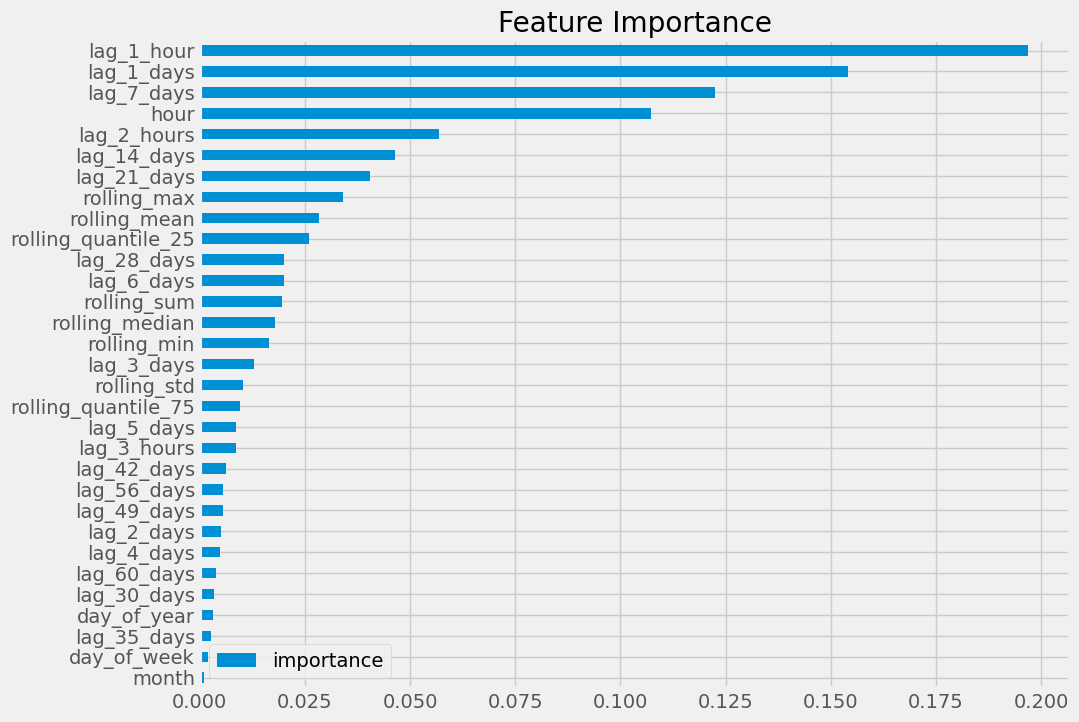

In [ ]:
feature_importance \
    .sort_values('importance') \
    .plot(kind='barh', title='Feature Importance', figsize=(10, 8))


In [ ]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])
future_with_features

,Traffic,date,day_of_week,month,day_of_year,hour,rolling_min,rolling_max,rolling_sum,rolling_mean,...,lag_56_days,lag_60_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,isFuture,pred
2018-07-02 01:00:00,NaN,2018-07-02 01:00:00,0,7,183,1,NaN,NaN,NaN,NaN,...,0.0326,0.01565,0.0198,0.0199,0.0228,0.0204,0.0181,0.0184,True,0.050323
2018-07-03 01:00:00,NaN,2018-07-03 01:00:00,1,7,184,1,NaN,NaN,NaN,NaN,...,0.0181,0.01565,NaN,0.0198,0.0199,0.0228,0.0204,0.0181,True,0.028060
2018-07-04 01:00:00,NaN,2018-07-04 01:00:00,2,7,185,1,NaN,NaN,NaN,NaN,...,0.0175,0.01880,NaN,NaN,0.0198,0.0199,0.0228,0.0204,True,0.028105
2018-07-05 01:00:00,NaN,2018-07-05 01:00:00,3,7,186,1,NaN,NaN,NaN,NaN,...,0.0212,0.02400,NaN,NaN,NaN,0.0198,0.0199,0.0228,True,0.029097
2018-07-06 01:00:00,NaN,2018-07-06 01:00:00,4,7,187,1,NaN,NaN,NaN,NaN,...,0.0238,0.03260,NaN,NaN,NaN,NaN,0.0198,0.0199,True,0.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-28 01:00:00,NaN,2018-09-28 01:00:00,4,9,271,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.025857
2018-09-29 01:00:00,NaN,2018-09-29 01:00:00,5,9,272,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.025857
2018-09-30 01:00:00,NaN,2018-09-30 01:00:00,6,9,273,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.025857
2018-10-01 01:00:00,NaN,2018-10-01 01:00:00,0,10,274,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.025857


In [ ]:
# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Traffic Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Traffic</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Traffic Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Traffic Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

In [ ]:
# Record the end time
end_time = time.time()

# Calculate the total run time
total_run_time = end_time - start_time
print("Total run time:", total_run_time, "seconds")

Total run time: 28.084774255752563 seconds
